In [1]:
!git clone https://github.com/bemc22/GeneralizedR2R
%cd GeneralizedR2R
!pip install -r requirements.txt

Cloning into 'GeneralizedR2R'...
remote: Enumerating objects: 389, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 389 (delta 31), reused 20 (delta 7), pack-reused 325 (from 1)
Receiving objects: 100% (389/389), 53.42 MiB | 11.68 MiB/s, done.
Resolving deltas: 100% (164/164), done.
/content/GeneralizedR2R
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 29.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 11.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 38.4 MB/s e

In [2]:
r"""
Self-supervised learning with Generalized Recorrupted-to-Recovered (GR2R)

Poisson Denoising Example
====================================================================================================

This example shows you how to train a reconstruction network for an denoising problem on a fully self-supervised way, i.e., using corrupted measurement data only.
"""

import os
import deepinv as dinv
from torch.utils.data import DataLoader
import torchvision
import torch
import numpy as np
from pathlib import Path
from torchvision import transforms
from deepinv.optim.prior import PnP
from deepinv.utils.demo import load_dataset, load_degradation
import wandb
import argparse
from torch.utils.data import DataLoader, random_split
from deepinv.loss import PSNR, SSIM, Loss, SupLoss
import matplotlib.pyplot as plt



/usr/local/lib/python3.10/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [3]:
def get_weights_url(file_name):
    return (
        "https://huggingface.co/bemc22/"
        + "GeneralizedR2R"
        + "/resolve/main/"
        + file_name
        + "?download=true"
    )

In [4]:
# ---------------------------------------------------------------
# Setup paths for data loading and results.
# ---------------------------------------------------------------

BASE_DIR = Path(".")
# PROJECT_NAME = "denoising-poisson-exp-newloss"
PROJECT_NAME = "denoising-poisson"
ORIGINAL_DATA_DIR =  Path("./data")
DATA_DIR = ORIGINAL_DATA_DIR / "measurements"
RESULTS_DIR = BASE_DIR / "results"
DEG_DIR = BASE_DIR / "degradations"
CKPT_DIR = BASE_DIR / "ckpts" / PROJECT_NAME

# Set the global random seed from pytorch to ensure reproducibility of the example.
device = dinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"


Selected GPU 0 with 15099 MB free memory 


In [5]:
def run(args, batch_id=0, weights_id=0):
    # print  all the arguments
    print(args)

    trial_id = args.trial
    torch.manual_seed(trial_id)

    run_name = f"{args.loss}-{args.noise}"

    wandb_setup = {
        "project": PROJECT_NAME,
        "config": args,
        "name": run_name,
    }

    operation = f"Denoising_{args.noise}"
    train_dataset_name = "div2k"
    # # ----------------------------------------------------------------------------------
    # Generate a dataset of images and load it.
    # ----------------------------------------------------------------------------------
    physics = dinv.physics.Denoising(noise_model=dinv.physics.PoissonNoise(args.noise))

    # Use parallel dataloader if using a GPU to fasten training,
    # otherwise, as all computes are on CPU, use synchronous data loading.
    num_workers = 0 if torch.cuda.is_available() else 0
    n_images_max = 100

    my_dataset_name = "div2k_poisson"
    measurement_dir = DATA_DIR / train_dataset_name / operation

    # check if the dataset is already generated
    # if not, generate it
    if not os.path.exists(measurement_dir / f"{my_dataset_name}0.h5"):

        img_size = 224
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.RandomCrop((img_size, img_size))
            ])

        test_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.CenterCrop((512, 512))
        ])

        train_dataset    =  dinv.datasets.DIV2K(root=ORIGINAL_DATA_DIR, mode="train", transform=transform, download=True)
        test_dataset     =  dinv.datasets.DIV2K(root=ORIGINAL_DATA_DIR, mode="val", transform=test_transform, download=True)

        deepinv_datasets_path = dinv.datasets.generate_dataset(
            train_dataset=train_dataset,
            test_dataset=test_dataset,
            physics=physics,
            device=device,
            save_dir=measurement_dir,
            train_datapoints=n_images_max,
            num_workers=num_workers,
            dataset_filename=str(my_dataset_name),
        )

    else:
        deepinv_datasets_path = measurement_dir / f"{my_dataset_name}0.h5"

    train_dataset = dinv.datasets.HDF5Dataset(path=deepinv_datasets_path, train=True)
    test_dataset = dinv.datasets.HDF5Dataset(path=deepinv_datasets_path, train=False)


    # Set up the reconstruction network
    # ---------------------------------------------------------------

    n_channels = 3

    model = dinv.models.DRUNet( in_channels=n_channels,
                                out_channels=n_channels,
                                pretrained=None,
                                nc=[16, 32, 64, 128],
                                train=True,
                                last_act="relu").to(device)

    # print number of parameters
    print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")


    # Set up the training parameters
    # --------------------------------------------
    noise_level   = args.noise


    if args.loss == "sup":   # SUPERVISED LOSS
        loss = dinv.loss.SupLoss()

    elif args.loss == "gr2r": # EQUIVARIANT RECORRUPTED LOSS

        def poisson_nll_loss(y_pred, y_true):
            return torch.nn.functional.poisson_nll_loss(y_pred / noise_level,
                                                        y_true / noise_level,
                                                        log_input=False,
                                                        full=False,
                                                        eps=1e-4)

        r2r_loss = dinv.loss.R2RPoissonLoss(metric=poisson_nll_loss, gain=noise_level, p=0.2)# p=0.1)
        loss     = [ r2r_loss ]
        model    = r2r_loss.adapt_model(model, MC_samples=10)

    if args.loss == "neigh": # GENERALIZED R2R LOSS - NLL VARIANT

        neigh_loss = dinv.loss.Neighbor2Neighbor()
        loss = [ neigh_loss ]

    elif args.loss == "gr2r_mse": # GENERALIZED R2R LOSS - MSE VARIANT

        r2r_loss = dinv.loss.R2RPoissonLoss(metric=torch.nn.MSELoss(), gain=noise_level, p=0.1)
        loss     = [ r2r_loss ]
        model    = r2r_loss.adapt_model(model, MC_samples=5)

    test_dataloader = DataLoader(
        test_dataset, batch_size=1, num_workers=num_workers, shuffle=False
    )


    filename = f"drunet_gr2r_poisson_0p1.pth.tar"
    url = get_weights_url(file_name=filename)
    ckpt = torch.hub.load_state_dict_from_url(
                    url, map_location=lambda storage, loc: storage, file_name=filename
                )

    model.load_state_dict(ckpt["state_dict"])

    model.eval()

    logs = {}

    for iter, batch in enumerate(test_dataloader):

        if iter != batch_id:
            continue

        x, y = batch

        x = x.to(device)
        y = y.to(device)

        x_net = model(y, physics)

        psnr_val =  PSNR()(x=x, x_net=x_net, y=y, physics=physics).item()
        ssim_val = SSIM()(x=x, x_net=x_net, y=y, physics=physics).item()

        logs["x_est"] = x_net
        logs["psnr"] = psnr_val
        logs["ssim"] = ssim_val

    print(args.loss, args.noise, logs["psnr"], logs["ssim"])

    return logs, x, y


In [6]:
class Args:
    loss        = "gr2r_mse"
    noise       = 0.1
    trial       = 0
    alpha       = 0.2

args = Args()

  0%|          | 0/3530603713 [00:00<?, ?it/s]

Extracting:   0%|          | 0/801 [00:00<?, ?it/s]

Dataset has been successfully downloaded.


  0%|          | 0/448993893 [00:00<?, ?it/s]

Extracting:   0%|          | 0/101 [00:00<?, ?it/s]

Dataset has been successfully downloaded.
Dataset has been saved in data/measurements/div2k/Denoising_0.1
Number of parameters: 2040816


Downloading: "https://huggingface.co/bemc22/GeneralizedR2R/resolve/main/drunet_gr2r_poisson_0p1.pth.tar?download=true" to /root/.cache/torch/hub/checkpoints/drunet_gr2r_poisson_0p1.pth.tar
100%|██████████| 23.4M/23.4M [00:00<00:00, 35.4MB/s]


gr2r_mse 0.1 33.4964714050293 0.859496590958829


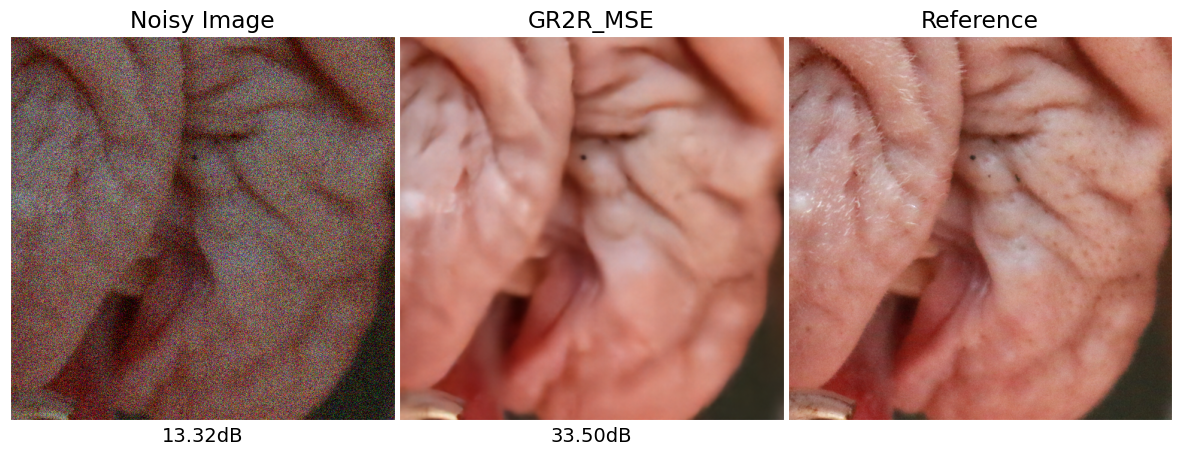

Number of parameters: 2040816
gr2r_mse 0.1 31.977962493896484 0.8980104243040672


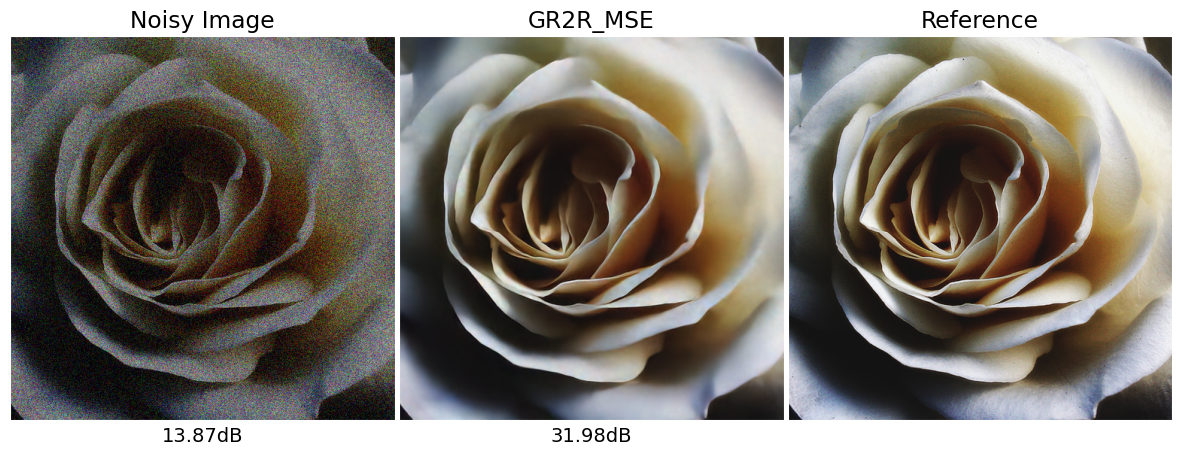

Number of parameters: 2040816
gr2r_mse 0.1 27.036331176757812 0.7773988664638918


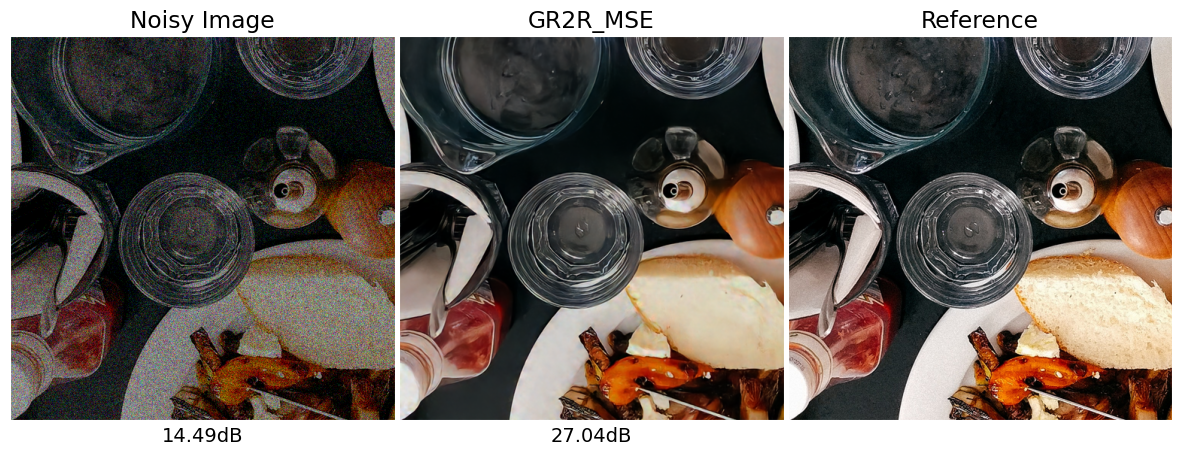

Number of parameters: 2040816
gr2r_mse 0.1 26.301786422729492 0.8304307353646099


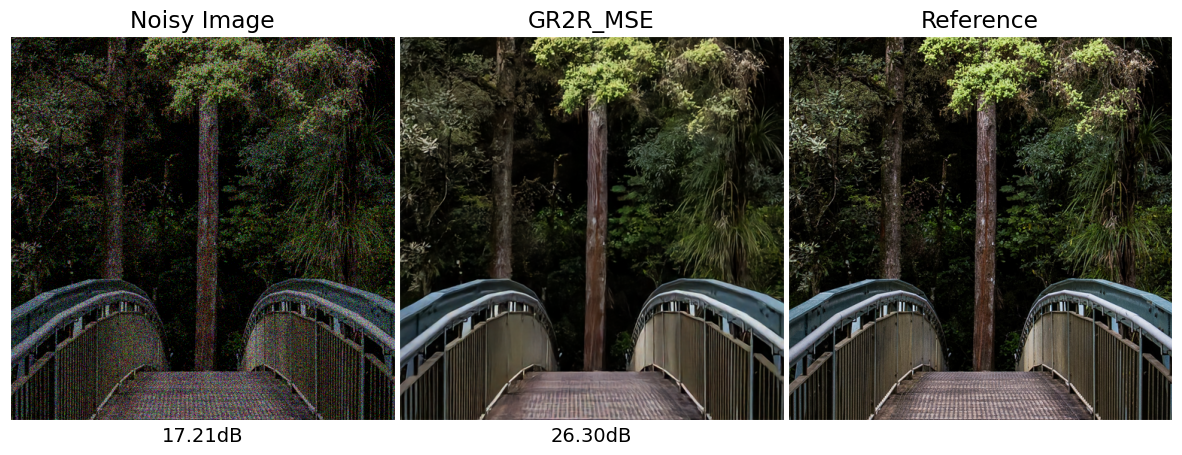

Number of parameters: 2040816
gr2r_mse 0.1 31.57965087890625 0.9073047394024912


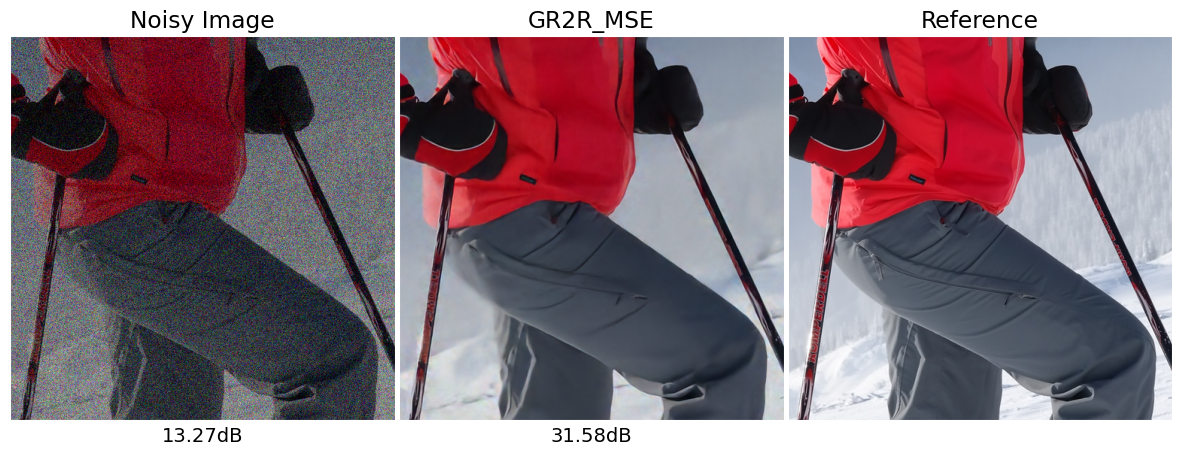

In [7]:
for kk in range(5):
    batch_id = kk
    loss = [
        ["gr2r_mse", -1],
    ]


    plt.rcParams['text.usetex'] = False
    plt.rcParams.update({'font.size': 14})

    fig, ax = plt.subplots(1, len(loss) + 2, figsize=(15, 5))

    plot_title = True

    for j, l in enumerate(loss):
        loss_name =  l[0]
        args.loss = loss_name
        logs, x, y = run(args, batch_id, l[1])

        x_est = logs["x_est"].cpu().detach().numpy().squeeze()
        x_est = x_est.transpose(1, 2, 0)

        x_est = (x_est - x_est.min()) / (x_est.max() - x_est.min())
        x_est = x_est[::-1, ...]

        ax[j+1].imshow(x_est, origin="lower")


        ax[j+1].set_xlabel(f"{logs['psnr']:.2f}dB", c="black")
        if plot_title:
            ax[j+1].set_title(f"{loss_name.upper()}")
        ax[j+1].set_xticks([])
        ax[j+1].set_yticks([])

        # set image border in white
        for spine in ax[j+1].spines.values():
            spine.set_edgecolor('white')

    x_plot = x.squeeze().cpu().detach().numpy().transpose(1, 2, 0)
    x_plot = (x_plot - x_plot.min()) / (x_plot.max() - x_plot.min())
    x_plot = x_plot[::-1, ...]

    ax[-1].imshow(x_plot, origin="lower")

    if plot_title:
        ax[-1].set_title("Reference")
    ax[-1].set_xticks([])
    ax[-1].set_yticks([])

    for spine in ax[-1].spines.values():
        spine.set_edgecolor('white')

    y_plot = y.squeeze().cpu().detach().numpy().transpose(1, 2, 0)
    y_plot = np.log(1 + y_plot)
    y_plot = (y_plot - y_plot.min()) / (y_plot.max() - y_plot.min())

    y_plot = y_plot[::-1, ...]
    ax[0].imshow(y_plot, origin="lower")


    psnr_baseline = PSNR()(x=x, x_net=y).item()

    if plot_title:
        ax[0].set_title("Noisy Image")
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].set_xlabel(f"{psnr_baseline:.2f}dB", c="black")

    for spine in ax[0].spines.values():
        spine.set_edgecolor('white')

    # reduce space between subplots
    plt.subplots_adjust(wspace=0.01, hspace=0.1)
    plt.show()
